
# Randomized Response (Bayesian) — Smoking Prevalence with Stan + cmdstanpy

* From ChatGPT 5

**Design**: A fair coin is flipped per respondent.  
- If **Heads** (앞면), they must answer **YES** (forced YES).  
- If **Tails** (뒷면), they answer **truthfully**.  

Observed: out of **N = 100**, **YES = 80**, **NO = 20**.  
Forced-YES probability: **p = 0.5**.

Let the true smoking prevalence be $ \theta $. 

Then the probability of observing YES is  
$$
 q = p + (1-p)\,\theta.
$$  
The data model is \( Y \sim \text{Binomial}(N, q) \).  
We use a Beta prior on \(\theta\), \(\theta \sim \text{Beta}(\alpha, \beta)\).

This notebook compiles a Stan model, samples using **cmdstanpy**, and visualizes posterior summaries.



## 0. Environment Setup

- You need **CmdStan** installed for `cmdstanpy` to run Stan models.
- The cell below will install `cmdstanpy` (if needed) and attempt to install CmdStan to your home directory (first-time only).
- If you already have CmdStan installed, you can skip the `install_cmdstan()` step and set the `CMDSTAN` environment variable accordingly.

아래 셀이 성공하면 다시 실행할 필요 없습니다.

In [1]:

# If you don't have cmdstanpy installed, uncomment the next line:
!pip install cmdstanpy

# Optional: install CmdStan (first time only). This may take several minutes.
from cmdstanpy import install_cmdstan
install_cmdstan(compiler=True, overwrite=True)
# After installation, you can check with:
import os
print("CMDSTAN path:", os.environ.get("CMDSTAN"))


Defaulting to user installation because normal site-packages is not writeable
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)


C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:38:55 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\yongd\.cmdstan\RTools40


CmdStan install directory: C:\Users\yongd\.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: C:\Users\yongd\AppData\Local\Temp\tmpk9snt8_3
Extracting distribution
Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.
Installed cmdstan-2.37.0
Test model compilation
CMDSTAN path: C:\Users\yongd\.cmdstan\cmdstan-2.37.0



## 1. Data & Hyperparameters

We set **N=100**, **YES=80**, **p=0.5** (forced YES probability).  
You can adjust the Beta prior by changing `alpha`, `beta`.


In [21]:

N = 100
y_yes = 80
p_forced = 0.5

# Prior: Beta(alpha, beta). Use (1,1) for uniform, (2,2) for mild shrinkage, etc.
alpha = 1.0
beta = 1.0

print({"N": N, "y_yes": y_yes, "p_forced": p_forced, "alpha": alpha, "beta": beta})

# Quick method-of-moments point estimate (not Bayesian): theta_hat = (q_hat - p)/(1-p)
q_hat = y_yes / N
theta_hat_mom = max(0.0, min(1.0, (q_hat - p_forced) / (1.0 - p_forced)))
print("Method-of-moments theta_hat (for reference only):", theta_hat_mom)


{'N': 100, 'y_yes': 80, 'p_forced': 0.5, 'alpha': 1.0, 'beta': 1.0}
Method-of-moments theta_hat (for reference only): 0.6000000000000001



## 2. Stan Model

We model:
- \( q = p + (1-p)\,\theta \)
- \( Y \sim \text{Binomial}(N, q) \)
- Prior: \( \theta \sim \text{Beta}(\alpha, \beta) \)

We also generate a posterior predictive replicate `y_rep` and record a transformed `theta_via_q`.


In [ ]:

stan_code = r"""
data {
  int<lower=0> N;                 // total respondents
  int<lower=0, upper=N> y_yes;    // observed YES count
  real<lower=0, upper=1> p_forced;// forced-YES probability (e.g., 0.5)
  real<lower=0> alpha;            // Beta prior alpha
  real<lower=0> beta;             // Beta prior beta
}
parameters {
  real<lower=0, upper=1> theta;   // true prevalence
}

model {
  real q;
  theta ~ beta(alpha, beta);
  q = p_forced + (1.0 - p_forced) * theta;
  y_yes ~ binomial(N, q);
}
"""

#   q = p_forced + (1.0 - p_forced) * theta;_code)

print("Wrote Stan model to rr_yes_model.stan")


Wrote Stan model to rr_yes_model.stan



## 3. Compile & Sample with cmdstanpy


In [27]:

import os
from cmdstanpy import CmdStanModel

# Compile the Stan model
model = CmdStanModel(stan_file="rr_yes_model.stan")

# Prepare data dict for Stan
data = {
    "N": N,
    "y_yes": y_yes,
    "p_forced": p_forced,
    "alpha": alpha,
    "beta": beta,
}

# Sample
fit = model.sample(
    data=data,
    chains=4,
    parallel_chains=4,
    iter_warmup=1000,
    iter_sampling=1000,
    adapt_delta=0.9,
    seed=20251008
)

print(fit.diagnose())

# Summaries
summary = fit.summary()
summary


15:32:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:32:23 - cmdstanpy - INFO - CmdStan done processing.



Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-51.964400,0.020650,0.711218,0.306010,-53.403100,-51.692600,-51.467500,1442.85,1422.25,68707.2,1.00127
theta,0.589148,0.002110,0.078328,0.078435,0.456976,0.592514,0.712403,1378.00,1439.14,65619.1,1.00137
y_rep,79.421300,0.123108,5.624830,5.930400,70.000000,80.000000,88.000000,2090.69,2520.76,99556.5,1.00012



## 4. Extract Posterior & Summaries


In [28]:

import numpy as np
import pandas as pd

theta = fit.stan_variable("theta")
y_rep = fit.stan_variable("y_rep")

# Compute credible interval helper

def cred_int(x, level=0.95):
    lo = (1 - level) / 2
    hi = 1 - lo
    return np.quantile(x, lo), np.quantile(x, hi)

theta_mean = float(np.mean(theta))
theta_lo, theta_hi = cred_int(theta, 0.95)

print(f"Posterior mean theta: {theta_mean:.3f}")
print(f"95% CrI for theta: [{theta_lo:.3f}, {theta_hi:.3f}]")

# Save posterior draws to CSV for external use if needed
post = pd.DataFrame({
    "theta": theta,
    "y_rep": y_rep,
})
post.to_csv("posterior_draws.csv", index=False)
print("Saved posterior draws -> posterior_draws.csv")


Posterior mean theta: 0.589
95% CrI for theta: [0.423, 0.731]
Saved posterior draws -> posterior_draws.csv



## 5. Visualizations

We plot:
1. Posterior density of \(\theta\)  
2. Posterior density of \(q\)  
3. Posterior predictive distribution of `y_rep`  
4. ECDF of \(\theta\)


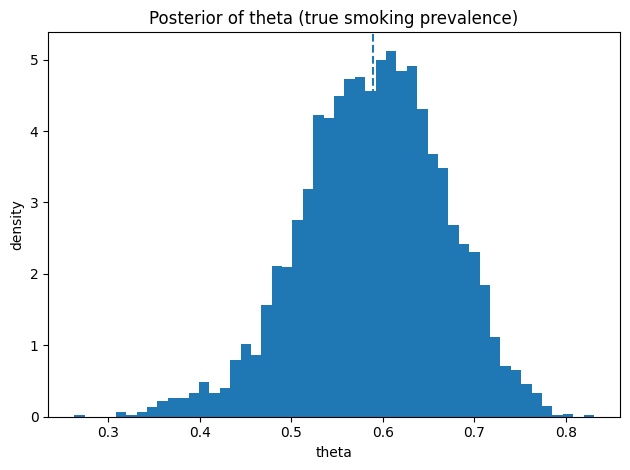

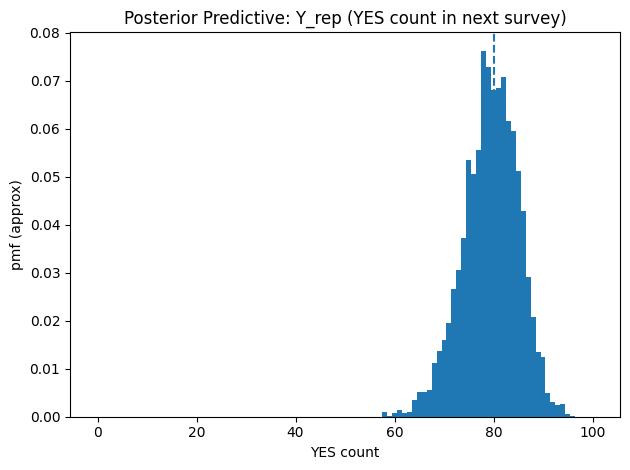

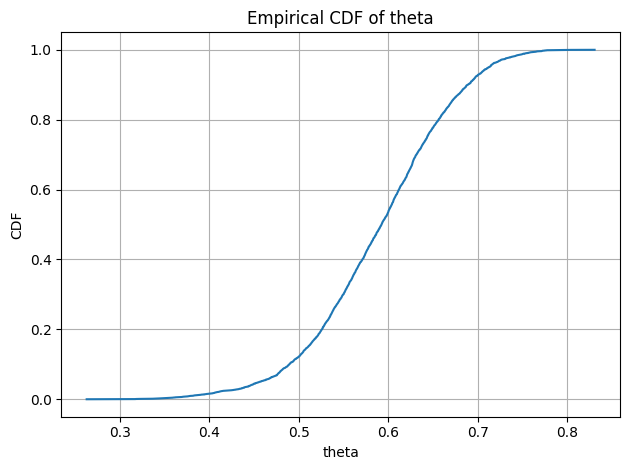

In [31]:

import matplotlib.pyplot as plt

# (A) Posterior of theta
plt.figure()
plt.hist(theta, bins=50, density=True)
plt.axvline(theta_mean, linestyle='--')
plt.title("Posterior of theta (true smoking prevalence)")
plt.xlabel("theta")
plt.ylabel("density")
plt.tight_layout()
plt.show()

# (B) Posterior predictive of y_rep
plt.figure()
plt.hist(y_rep, bins=range(0, N+2), align='left', density=True)
plt.axvline(y_yes, linestyle='--')
plt.title("Posterior Predictive: Y_rep (YES count in next survey)")
plt.xlabel("YES count")
plt.ylabel("pmf (approx)")
plt.tight_layout()
plt.show()

# (C) ECDF of theta
theta_sorted = np.sort(theta)
cdf = np.linspace(0, 1, len(theta_sorted))
plt.figure()
plt.plot(theta_sorted, cdf)
plt.title("Empirical CDF of theta")
plt.xlabel("theta")
plt.ylabel("CDF"); plt.grid(True);
plt.tight_layout()
plt.show()



## 6. Notes & Extensions

- **Misclassification**: Add small-error probabilities for forced/true responses to model careless errors.  
- **Hierarchical Groups**: If multiple cohorts/years, model \(\theta_g\) with a hierarchical Beta prior.  
- **Different Randomizers**: If \(p\neq 0.5\) or rules are asymmetric, replace `p_forced` accordingly.

Feel free to modify priors (`alpha`, `beta`) to reflect domain knowledge.
